<h1 title><center>NLP Challenge</center></h1>
<p><center style="font-size:120%;">Dataset: Olist (order reviews)</center></p>

## Importing libraries

In [ ]:
import pandas as pd
import re
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import spacy.cli
spacy.cli.download("pt_core_news_sm")
import pt_core_news_sm

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


##Data exploration

In [ ]:
# Loading dataset
order_reviews_df = pd.read_csv("/content/olist_order_reviews_dataset.csv")

In [ ]:
# Checking the first 5 records
order_reviews_df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [ ]:
# Checking the shape
# 57.560 rows
# 7 columns
order_reviews_df.shape

(57560, 7)

In [ ]:
# Removing unnecessary columns
order_reviews_df.drop(["order_id", "review_creation_date", "review_answer_timestamp"], 1, inplace = True)

<ipython-input-6-47d189474c34>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  order_reviews_df.drop(["order_id", "review_creation_date", "review_answer_timestamp"], 1, inplace = True)


In [ ]:
# Checking for duplicate values
order_reviews_df[order_reviews_df.duplicated("review_id", keep =  False)].sort_values(by = "review_id")

,review_id,review_score,review_comment_title,review_comment_message
29841,00130cbe1f9d422698c812ed8ded1919,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid..."
46678,00130cbe1f9d422698c812ed8ded1919,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid..."
1988,03a6a25db577d0689440933055111897,5,NaN,Muito Bom! Gostei Bastante! Tecido Ótimo! Aten...
9013,03a6a25db577d0689440933055111897,5,NaN,Muito Bom! Gostei Bastante! Tecido Ótimo! Aten...
21587,0467560f511c516ddaa54a60edb0c291,5,NaN,NaN
...,...,...,...,...
31840,fb962e0e8c73e6e359ce7d34de8571ed,5,NaN,NaN
11895,fc906850133b4a339e3aad7b79dbfa7a,1,Não recebi até 28/04/20,NaN
38971,fc906850133b4a339e3aad7b79dbfa7a,1,Não recebi até 28/04/20,NaN
31120,fe5c833752953fed3209646f1f63b53c,1,NaN,"Comprei dois produtos e ambos, mesmo enviados ..."


In [ ]:
# Removing duplicate values
order_reviews_df.drop_duplicates("review_id", inplace = True)

In [ ]:
# Replacing null records with space
order_reviews_df.fillna('', inplace = True)

In [ ]:
# Joining the "review_comment_title" and "review_comment_message" columns
# This way, it is possible to get more reviews, since there are users
# that only filled in the "comment_title" and not the "comment_message"
order_reviews_df["full_review"] = order_reviews_df["review_comment_title"] + ' ' + order_reviews_df["review_comment_message"]

In [ ]:
# Viewing the dataset with the new column "full_review"
order_reviews_df.head()

,review_id,review_score,review_comment_title,review_comment_message,full_review
0,7bc2406110b926393aa56f80a40eba40,4,,,
1,80e641a11e56f04c1ad469d5645fdfde,5,,,
2,228ce5500dc1d8e020d8d1322874b6f0,5,,,
3,e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...


In [ ]:
# Removing entries without text
order_reviews_df= order_reviews_df[order_reviews_df["full_review"] != ' ']

In [ ]:
# Grouping the "review_score" and counting reviews by "review_score"
review_score_groupby = order_reviews_df.groupby(["review_score"])["review_score"].count()
review_score_groupby

# We concluded that customers gave reviews from 1 to 5.
# Below we can see the total number of reviews by score.

review_score
1     5109
2     1245
3     2125
4     3654
5    12589
Name: review_score, dtype: int64

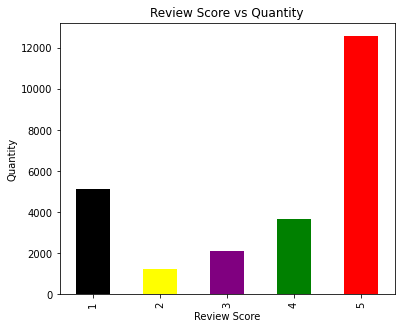

In [ ]:
# Generating a bar chart

review_score_groupby.plot(kind="bar", title="Review Score vs Quantity", ylabel="Quantity",
         xlabel="Review Score",color=["black", "yellow","purple","green","red"], figsize=(6, 5))

# Through this graph, we can conclude that the majority of reviews have a rating of 5,
# i.e. the maximum grade.

## <center style="color:blue;"> Note 1</center>
### <center>As the goal of this challenge is to build a classification model, we will need to create one more column that will be our class. Therefore, we will establish that:</center>
### <center style="color:red;">"review_score" less than or equal to 3, will be classified as negative (receiving the value 0)</center>
### <center style="color:green;">"review_score" greater than or equal to 4, will be classified as positive (receiving the value 1)</center>

In [ ]:
# Creation of the list "class_num_list" that will receive the values ​​corresponding to each class
class_num_list = []

# For loop that iterates through the "review_score" column, assigns the appropriate values, and appends them to the "class_num_list"
for c in order_reviews_df['review_score']:
  if c > 3:
    class_num_list.append(1)
  else:
    class_num_list.append(0)


In [ ]:
# Adding the "class_num" column with the values ​​from "class_list_num"
order_reviews_df['class_num'] = class_num_list

In [ ]:
# Grouping the "class_column" column and counting the negative (0) and positive (1) records
class_groupby = order_reviews_df.groupby(["class_num"])["class_num"].count()
class_groupby

# Here we can see that our database is unbalanced,
# since there are more positive records than negative ones.

# As the calculations below show, we can see that positive records(1)
# correspond to 65.7% of the total database, against 34.3% of negative records (0).

class_num
0     8479
1    16243
Name: class_num, dtype: int64

In [ ]:
# Calculating the percentage of positive records in the database
((class_groupby[1]/order_reviews_df.shape[0])*100).round(decimals=2)

65.7

In [ ]:
# Calculating the percentage of negative records in the database
((class_groupby[0]/order_reviews_df.shape[0])*100).round(decimals=2)

34.3

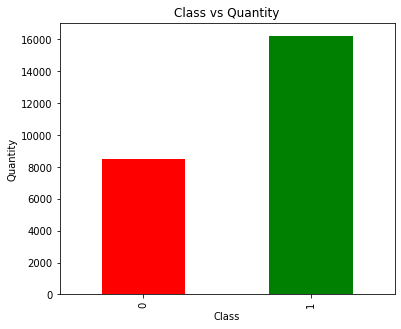

In [ ]:
# Generating a bar chart
class_groupby.plot(kind="bar", title="Class vs Quantity", ylabel="Quantity",
         xlabel="Class",color=["red","green"], figsize=(6, 5))

## Text preprocessing

In [ ]:
# Defining the "stop_words" variable
# "stop_words" are sets of words most used in a language.
# Stop words allow the algorithm to focus on the words important and eliminate unimportant words.
stop_words = stopwords.words("portuguese")
stop_words[:4]

['a', 'à', 'ao', 'aos']

In [ ]:
# Removal of "stop_words": "não" and "nem"
# As we are dealing with reviews, the words "no" and "neither" are important for sentiment analysis, so let's remove them from the "stop_words"
stop_words.remove('não')
stop_words.remove('nem')

In [ ]:
# Creating the variable "nlp", which loads "pt_core_news_sm".
# "pt_core_news_sm" is a CPU-optimized Portuguese pipeline.
# It's components are: tok2vec, morphologizer, parser, lemmatizer (trainable_lemmatizer), senter, ner, attribute_ruler.
nlp = pt_core_news_sm.load()

In [ ]:
# Function that will pre-process the "full_review" column
def pre_processing(text):
  # Transform text to lowercase letters
  text = text.lower()

  # Filters unwanted characters, replacing what is in the regex with a blank space " ".
  # Regex (regular expression): "[\W\d_]+":
  # "\W" = any character that is not a word character
  # (alphanumeric and underscore). Equivalent to [^A-Za-z0-9_]
  # "\d" = matches any digit character (0-9).
  # "_" = matches a "_" character
  # "+" = matches 1 or more of the previous token
  text = re.sub(r"[\W\d_]+", " ", text)

  # Remove stop words
  text = [word for word in text.split() if word not in stop_words]

  # Perform lemmatization
  # Lemmatization is the act of representing words through the infinitive
  # of verbs and masculine singular of nouns and adjectives.
  # "-PRON-" = personal pronouns (spacy)
  phrase  = nlp(" ".join(text))

  # Perform tokenization
  # Tokenization's main objective is to transform sentences into a sequence of tokens,
  # in other words, it is a process that creates a vector, in which the sentence is represented in numbers.
  tokens = [word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in phrase ]

  return " ".join(tokens)

In [ ]:
# Selecting a random phrase
random_phrase = order_reviews_df.iloc[45][4]
random_phrase

' Produto chegou, mas meu PC não conseguiu reconhecer as portas USB.'

In [ ]:
# Testing the preprocessing function
test = pre_processing(random_phrase)
test

'produto chegar pc não conseguir reconhecer porta usb'

In [ ]:
# Applying the preprocessing function to the "full_review" column
order_reviews_df["full_review"] = order_reviews_df["full_review"].apply(pre_processing)

In [ ]:
# Checking first 5 records after preprocessing
order_reviews_df.head()

,review_id,review_score,review_comment_title,review_comment_message,full_review,class_num
3,e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,recebi bem antes prazo estipular,1
4,f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,parabém loja lannister adorei comprar Internet...,1
9,8670d52e15e00043ae7de4c01cc2fe06,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente site marca aparel...,1
12,4b49719c8a200003f700d3d986ea1a19,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",pouco travar valor ta bom,1
15,3948b09f7c818e2d86c9a546758b2335,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",super recomendo vendedor confiável produto ok ...,1


In [ ]:
# Checking if there are still empty records in the "full_review" column
order_reviews_df[order_reviews_df["full_review"] == '']

# As you can see below, there are still empty records.

,review_id,review_score,review_comment_title,review_comment_message,full_review,class_num
297,2b4a570df87cd63b232272dd9dcac0cf,5,,A,,1
463,3140a4eb146655fe104d54d385f9e9a0,5,,10,,1
583,3814f35a6ebd64d27e2130f30ec05255,4,5,,,1
598,057c9a1e8e767d8bf6fa59ac43a82435,4,4,,,1
939,8f965d010b3119d9962e091de3425fb9,4,,*******************,,1
...,...,...,...,...,...,...
56043,8715867a859dacaef6122186fbf22fd9,5,,👍,,1
56498,e92c7e2c8591a747e9112eb06ca610b7,5,,.,,1
57001,3fa2a3568c29ea42966581856164a144,5,10,,,1
57136,e62b75cdc1bab5182f327f27cbae2c01,5,*************************,,,1


In [ ]:
# Removing empty records from the "full_review" column
order_reviews_df = order_reviews_df[order_reviews_df["full_review"] != '']

In [ ]:
# Saving the pre-processed dataset
order_reviews_df.to_csv('processed_dataset.csv', index= False, columns= ["full_review", "class_num"])

## Feature Extraction

###Method: TF-IDF (Term Frequency Inverse Document Frequency)

The TF-IDF method is made up of statistical measures to measure how important a word is in a document (text). Through it, it is possible to understand the importance of a word through punctuation.

This score is made by multiplying two terms: Term Frequency, which measures how often a term occurs in a document, and Inverse Document Frequency, which measures how important a term is in the context of all documents.





In [ ]:
# Creating the variable "tfidf" that will receive the TfidfVectorizer function
tfidf_vect = TfidfVectorizer(max_features=5000)

# "text" variable that receives the "full_review" column
text = order_reviews_df["full_review"]

# Doing the vectorization
X_tfidf = tfidf_vect.fit_transform(text)

In [ ]:
# Observing a sample of the vectorized result
print(X_tfidf[:1])

  (0, 1751)	0.6795199820074633
  (0, 3539)	0.3042703257328682
  (0, 321)	0.3500312909146224
  (0, 562)	0.42557280549685406
  (0, 3839)	0.3768793514285056


## Separating into training and testing datasets

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X_tfidf, order_reviews_df["class_num"],
                                                        test_size=0.3, random_state = 10)

## Model: Logistic regression - Accuracy: 89%

In [ ]:
# Creating the variable "reglog" that will receive the Logistic Regression
reglog = LogisticRegression()

# Training the model
reglog.fit(X1_train, y1_train)

# Predict
y1_reglog_pred = reglog.predict(X1_test)

In [ ]:
# Measuring accuracy
print("Acurácia: ", accuracy_score(y1_test, y1_reglog_pred))

Acurácia:  0.8983717774762551



Matriz de confusão:


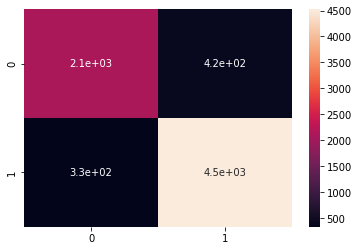

In [ ]:
# Confusion matrix
print("\nMatriz de confusão:")
sns.heatmap(confusion_matrix(y1_test, y1_reglog_pred), annot=True)
plt.show()

In [ ]:
# Classification Report
print(classification_report(y1_test, y1_reglog_pred))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      2518
           1       0.92      0.93      0.92      4852

    accuracy                           0.90      7370
   macro avg       0.89      0.88      0.89      7370
weighted avg       0.90      0.90      0.90      7370



###<center>Note 2</center>
####<center>Through this metrics report, we can see that the model has 90% accuracy.</center>
####<center> When it correctly classifies a class 0 (negative) review, it has 86% accuracy.</center>
####<center>When classifying a class 1 (positive) review, it has 92% accuracy. In other words, he is 92% sure that that review, in fact, belongs to class 1.</center>

##Testing the model with new sentences

In [ ]:
# Creation of the "new_reviews" list that receives new reviews
new_reviews = ["A experiencia foi horrível",
                "Eu não gostei do produto",
                "Super recomendo!",
                "A entrega atrasou demais. Péssimo vendedor!",
                "Amei! Virou meu ecommerce favorito"]

# Loop that iterates through each item in the list and performs sentiment analysis on each review
n = 1
for c in new_reviews:
  vectorized_text = tfidf_vect.transform([c])
  prediction = reglog.predict(vectorized_text)
  if prediction == 0:
    print("Review {}: {}; Classificação: Negativa {}".format(n, c, prediction))
  else:
    print("Review {}: {}; Classificação: Positiva {}".format(n, c, prediction))
  n+=1

Review 1: A experiencia foi horrível; Classificação: Negativa [0]
Review 2: Eu não gostei do produto; Classificação: Negativa [0]
Review 3: Super recomendo!; Classificação: Positiva [1]
Review 4: A entrega atrasou demais. Péssimo vendedor!; Classificação: Negativa [0]
Review 5: Amei! Virou meu ecommerce favorito; Classificação: Positiva [1]


## <center>Conclusion</center>
###<center> After testing the model with new reviews, we can conclude that, with these samples, the model performed as expected and made the classifications correctly. </center>

###<center> Still, there is always room for improvement. Therefore, a next step would be to test other classification algorithms and even neural networks to try to increase the model's accuracy.</center>

## <center>Extra Observations</center>
####<center> I would like to point out that, during the development of this challenge, I also tested the Random Forest algorithm and it returned an accuracy of 88%. As the Logistic Regression was a little better, I chose to leave it as the "final model" of the challenge. </center>

####<center> Furthermore, I also tested the model offered by the Spacy library, but it performed poorly with this database. Therefore, I decided to leave this option aside.</center>

In [ ]:
# Creating the "reglog" variable that will receive the Random Forest
rf = RandomForestClassifier()

# Training the model
rf.fit(X1_train, y1_train)

# Predict
y2_rf_pred = rf.predict(X1_test)

# Measuring accuracy
print("Acurácia: ", accuracy_score(y1_test, y2_rf_pred))

Acurácia:  0.8896879240162823
